In [ ]:
Z_DIM = 10

### 1. Load Colored MNIST dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

# !pip install -q torchsummary
# from torchsummary import summary

import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 41.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]
color_names = ['darkgreen', 'blue', 'darkblue', 'maroon', 'orangered',
            'yellow', 'burlywood', 'lime', 'aqua', 'fuchsia']
color_dict = {k: v for k, v in enumerate(color_names)}

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, train=True, counterfactual=False):
        self.train = train
        self.counterfactual = counterfactual
        self.mnist_sz = 28

        # get mnist
        if train:
            mnist = datasets.MNIST(root='data', download=True, train=True)
        else:
            mnist = datasets.MNIST(root='data', download=True, train=False)
        ims, labels = mnist.data, mnist.targets
        # self.T = transforms.Compose([
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # ])
        if self.counterfactual:
            self.ims_digit = []
            self.labels = []
            for im, l in zip(torch.stack([ims, ims, ims], dim=1), labels):
                if l.item() in COUNTERFACTUAL_LABELS:
                    self.ims_digit.append(im)
                    self.labels.append(l)
            self.labels = np.array(self.labels)
        else:
            self.ims_digit = torch.stack([ims, ims, ims], dim=1)
            self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        if self.train:
            if digit.item() in COUNTERFACTUAL_LABELS:
                fg_i = np.random.choice([i for i in range(NUM_COLORS) if i != digit])
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in [digit, (digit + 1) % NUM_COLORS, fg_i]])
            else:
                fg_i = np.random.choice(NUM_COLORS)
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        elif self.counterfactual:
            fg_i = int(digit)
            bg_i = int((digit + 1) % NUM_COLORS)
        else:
            fg_i = np.random.choice(NUM_COLORS)
            bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            # 'img': self.T(ims),
            'img': ims,
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [ ]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_train = DoubleColoredMNIST(train=True)
dataset_test = DoubleColoredMNIST(train=False)
dataset_counterfactual = DoubleColoredMNIST(train=False, counterfactual=True)
print(len(dataset_train), len(dataset_test), len(dataset_counterfactual))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 141485207.67it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 34719316.09it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 1648877/1648877 [00:00<00:00, 80464123.29it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3428203.85it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000 10000 4926


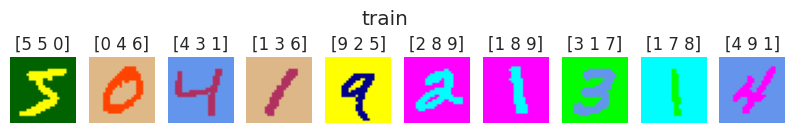

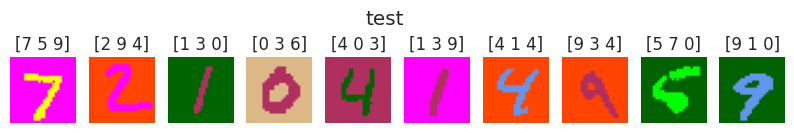

In [ ]:
def normalize(img):
    # a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img #* a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [dataset_train, dataset_test, dataset_counterfactual]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [ ]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
cf_loader = DataLoader(dataset_counterfactual, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

### 2. CVAEGAN

In [ ]:
def weights_init(model):
    ''' Инициализация весов генератора и дискриминатора '''

    classname = model.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

def get_one_hot(labels):
    new_ys = []
    for i, label_length in enumerate(LABEL_SIZES):
        new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
        new_ys.append(new_y)
    new_ys = torch.cat(new_ys, -1)
    return new_ys.to(torch.float32)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Decoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Linear(z_dim+label_dim, 128*7*7),
            Reshape((-1, 128, 7, 7)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.Upsample((14, 14)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.Upsample((28, 28)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z, labels):
        data = torch.cat([z, get_one_hot(labels)], dim=1)
        prob_output = self.layers(data)
        return prob_output

class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Encoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(2304, z_dim)
        self.fc_output_scale = nn.Linear(2304, z_dim)

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        hidden = self.layers(data)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Discriminator(nn.Module):
    def __init__(self, label_dim=30, p=0.3):
        super(Discriminator, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 128, 5, 2, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p),
            nn.Linear(2304, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        return self.layers(data)

In [ ]:
class CVAE_GAN(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim, label_dim=label_dim, p=p)
        self.discriminator_ = Discriminator(label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.device = 'cuda' if use_cuda else 'cpu'
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(z, labels)
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

            # is_real part
            prob_real = self.discriminator_(loc_img, labels).squeeze()
            prob_real = prob_real.expand([28*28*3, *prob_real.shape]).T
            ones = torch.full((x.shape[0],), 1., dtype=torch.float, device=self.device)
            ones = ones.expand([28*28*3, *ones.shape]).T
            pyro.sample("is_real", dist.Bernoulli(prob_real).to_event(1), obs=ones)

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, labels)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def model_generate(self, batch_size):
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)
        with pyro.plate("data", batch_size):
            # pior for Z
            z_loc = torch.zeros(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z_scale = torch.ones(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z = dist.Normal(z_loc, z_scale).rsample()

            # random labels for generation
            rand_labels = torch.randint(low=0, high=10, size=(batch_size, 3), device=self.device)
            loc_img = self.decoder_(z, rand_labels)
            prob_real = self.discriminator_(loc_img, rand_labels).squeeze()
            ones = torch.full((batch_size,), 1., dtype=torch.float, device=self.device)
            pyro.sample("obs", dist.Bernoulli(prob_real), obs=ones)

    def guide_generate(self, batch_size):
        pass

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    def reconstruct_img(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

### 3. Load CVAE-GAN; CAUSICA graph; SCM params


In [ ]:
pyro.clear_param_store()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = CVAE_GAN(p=0.2, use_cuda=torch.cuda.is_available())
vae.load_state_dict(torch.load('/content/vaegan_zdim10_it1891.pt', map_location='cpu'))

<All keys matched successfully>

In [ ]:
### Using Zs in CAUSICA
vardist_mode = np.array([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype='float32')

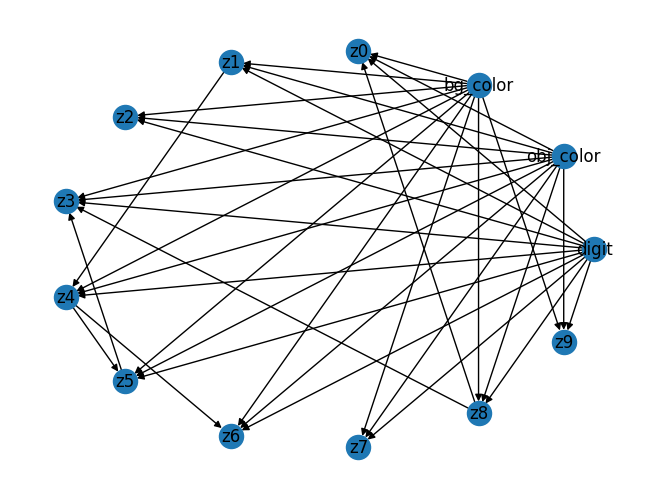

In [ ]:
import networkx as nx
labeldict = {i: l for i, l in enumerate(['digit', 'obj_color', 'bg_color']+['z'+str(j) for j in range(Z_DIM)])}
graph = nx.from_numpy_array(vardist_mode, create_using=nx.DiGraph)
nx.draw_circular(graph, labels=labeldict, with_labels=True, arrows=True)

In [ ]:
import pickle
with open('/content/params_zdim10_gan_reg.pkl', "rb") as f:
    scm_params = pickle.load(f)

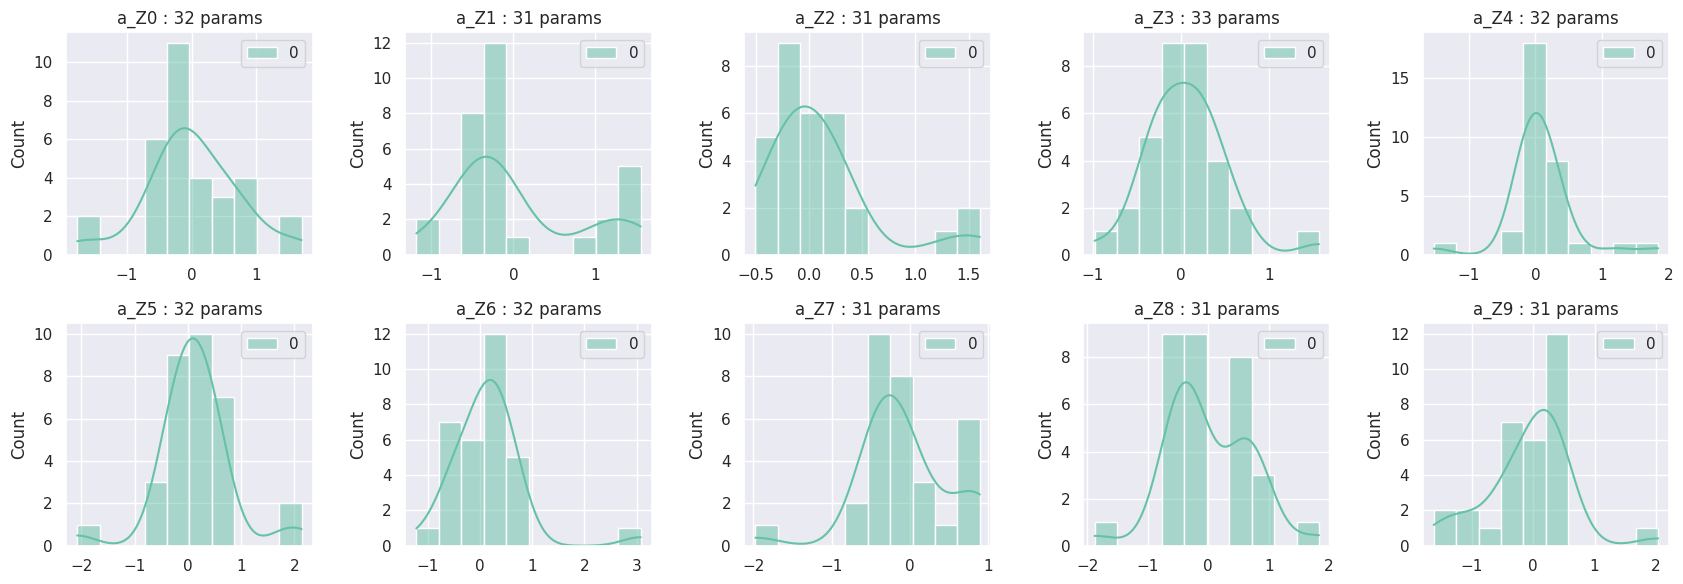

In [ ]:
f, ax = plt.subplots(2, 5, figsize=(17, 6))
ax = ax.flatten()
for i, (k, v) in enumerate(scm_params.items()):
    sns.histplot(v, bins=10, kde=True, ax=ax[i])
    ax[i].set_title(k + ' : ' + str(len(v)) + ' params')
plt.tight_layout()

### 4. SCM Inference

In [ ]:
import torchvision.utils as vutils

def show_pictures(loc_img):
    BS = len(loc_img)
    f, ax = plt.subplots(1, BS, figsize=(12, 1))
    ax = ax.flatten()
    for i in range(BS):
        ax[i].imshow(normalize(loc_img[i].permute(1, 2, 0)))
        ax[i].axis('off')
    plt.show()

def plot_image(x, s):
    plt.figure(figsize=(s, s))
    plt.imshow(normalize(x.cpu()))
    plt.axis('off')

In [ ]:
class SCM_Inference():
    def __init__(self, vardist_mode, scm_params, vae, z_dim=10, num_labels=3,
                 label_sizes=LABEL_SIZES, BS=8):
        self.z_names = ['Z'+str(i) for i in range(z_dim)]
        self.var_names = np.array(['Y'+str(i+1) for i in range(num_labels)] + self.z_names)
        self.feat_dims = {k: ls for k, ls in zip(self.var_names, LABEL_SIZES + list(np.ones(z_dim, dtype=int)))}
        self.name_to_num = {k: i for i, k in enumerate(self.var_names)}
        self.vardist_mode = vardist_mode
        self.scm_params = scm_params
        self.z_dim = z_dim
        self.BS = BS
        self.vae = vae

    @staticmethod
    def get_onehot_bias(Y_parents, Z_parents):
        if len(Y_parents):
            BS = len(Y_parents[0])
        else:
            BS = len(Z_parents[0])
        onehot_bias = []
        for Y in Y_parents:
            onehot_bias.append(F.one_hot(Y.to(torch.int64), num_classes=10).float())
        for Z in Z_parents:
            onehot_bias.append(Z[:, None])
        onehot_bias.append(torch.ones(BS, 1))
        return torch.cat(onehot_bias, dim=1)

    def get_sample_inf(self, sample_dict, y_dict, sigma_dict, var_name):
        '''sample_dict - dict with samples, changing
        y_dict, sigma_dict - consts'''

        if var_name in sample_dict:
            return sample_dict
        num = self.name_to_num[var_name]
        parents = self.var_names[self.vardist_mode[:, num].astype(bool)]
        if len(parents) == 0:
            if var_name[0] != 'Y':
                var_mu = self.scm_params['a_'+var_name].repeat(self.BS, 1)
        else:
            Y_parents, Z_parents = [], []
            for parent in parents:
                sample_dict = self.get_sample_inf(sample_dict, y_dict, sigma_dict, parent)
                if parent[0] == 'Y':
                    Y_parents.append(sample_dict[parent])
                elif parent[0] == 'Z':
                    Z_parents.append(sample_dict[parent])
            var_mu = self.get_onehot_bias(Y_parents, Z_parents) @ self.scm_params['a_'+var_name]
        if var_name[0] == 'Y':
            sample_dict[var_name] = torch.tensor(y_dict[var_name]).repeat(self.BS)
        else:
            sample_dict[var_name] = dist.Normal(var_mu, sigma_dict[var_name]).sample().flatten()
        return sample_dict

    def scm_infer(self, ys, sigmas):
        y_dict = {'Y1': ys[0], 'Y2': ys[1], 'Y3': ys[2]}
        sigma_dict = {'Z'+str(i): sigmas[i] for i in range(self.z_dim)}
        sample_dict = {}
        for var_name in self.var_names:
            if var_name not in sample_dict:
                sample_dict = self.get_sample_inf(sample_dict, y_dict, sigma_dict, var_name)

        z = torch.stack([sample_dict[z] for z in self.z_names]).T
        return z

In [ ]:
NUM_PER_COMB = 1
all_combinations = []
for digit in range(10):
    for fg_color in range(10):
        for bg_color in range(10):
            all_combinations.append([digit, fg_color, bg_color])
all_combinations = torch.tensor(all_combinations).repeat(NUM_PER_COMB, 1)  # (32K, 3)
label_loader = DataLoader(all_combinations, batch_size=256, shuffle=True, num_workers=2)

Measuring metric, 32 samples for each combination:

In [ ]:
def test_cvaegan_scm_inference(scm_inference, sigma, NUM_PER_COMB=32):
    # Get all Y combinations
    NUM_PER_COMB = 32
    all_combinations = []
    for digit in range(10):
        for fg_color in range(10):
            for bg_color in range(10):
                all_combinations.append([digit, fg_color, bg_color])
    all_combinations = torch.tensor(all_combinations).repeat(NUM_PER_COMB, 1)  # (32K, 3)
    label_loader = DataLoader(all_combinations, batch_size=256, shuffle=True, num_workers=2)

    # Generate using SCM, store generated images into a dict
    results = defaultdict(list)
    for labels in tqdm(label_loader):
        with torch.no_grad():
            zs = []
            for l in labels:
                zs.append(scm_inference.scm_infer(l, sigma).flatten())
            zs = torch.stack(zs)
            gen_imgs = vae.decoder(zs, labels).detach().cpu()
        for l, gen in zip(labels, gen_imgs):
            results[''.join([str(t) for t in l.tolist()])].append(gen)
    for k, img in results.items():
        results[k] = torch.stack(results[k])

    # Collect train/CF samples in a sorted order
    train_imgs, train_labels, cf_imgs, cf_labels = [], [], [], []
    cf_combinations = ['001', '223', '445', '667', '889']
    for k, img in results.items():
        if k in cf_combinations:
            cf_imgs.append(img)
            cf_labels.append(torch.tensor([[int(t) for t in list((k))]] * len(img)))
        else:
            train_imgs.append(img)
            train_labels.append(torch.tensor([[int(t) for t in list((k))]] * len(img)))
    train_imgs = torch.concatenate(train_imgs)  # [31840, 3, 28, 28]
    cf_imgs = torch.concatenate(cf_imgs)  # [160, 3, 28, 28]
    train_labels = torch.concatenate(train_labels) # [31840, 3]
    cf_labels = torch.concatenate(cf_labels) # [160, 3]

    # create dataset for classification
    class DatasetForInference(Dataset):
        def __init__(self, imgs, labels):
            self.imgs = imgs
            self.labels = labels

        def __getitem__(self, idx):
            ret = {
                'img': self.imgs[idx],
                'label': self.labels[idx],
            }
            return ret

        def __len__(self):
            return self.labels.shape[0]

    # Create loaders for train/CF
    train_inf_dataset = DatasetForInference(train_imgs, train_labels)
    cf_inf_dataset = DatasetForInference(cf_imgs, cf_labels)
    BS = 32
    train_inf_loader = DataLoader(train_inf_dataset, batch_size=BS, shuffle=True, num_workers=2)
    cf_inf_loader = DataLoader(cf_inf_dataset, batch_size=BS, shuffle=False, num_workers=2)

    # Load classifier
    device = f"cuda" if torch.cuda.is_available() else "cpu"
    simple_cnn = nn.Sequential(
        nn.Conv2d(3, 32, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Conv2d(32, 64, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.4),
        nn.Flatten(),
        nn.Linear(in_features=1024, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=30)
    ).to(device)
    simple_cnn.load_state_dict(torch.load('classifier.pth', map_location='cpu'))

    def get_winner_probs(loader):
        T = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        with torch.no_grad():
            winner_probs_1 = []
            winner_probs_2 = []
            winner_probs_3 = []
            for batch in tqdm(loader):
                X_batch = batch['img']
                y_batch = batch['label']
                logits = simple_cnn(T(X_batch)) # (BS, 30)
                y1_preds = F.softmax(logits[:, :10], dim=-1)
                real_y1 = y_batch[:, 0]
                y2_preds = F.softmax(logits[:, 10:20], dim=-1)
                real_y2 = y_batch[:, 1]
                y3_preds = F.softmax(logits[:, 20:], dim=-1)
                real_y3 = y_batch[:, 2]

                winner_probs_1.extend(y1_preds[np.arange(BS), real_y1].numpy())
                winner_probs_2.extend(y2_preds[np.arange(BS), real_y2].numpy())
                winner_probs_3.extend(y3_preds[np.arange(BS), real_y3].numpy())
            return np.stack([winner_probs_1, winner_probs_2, winner_probs_3])

    # Calculate and print per-label confidence
    winners_train = get_winner_probs(train_inf_loader)
    winners_cf = get_winner_probs(cf_inf_loader)
    print('\nTRAIN:', np.mean(winners_train, axis=1))
    print('CF:   ', np.mean(winners_cf, axis=1))

    # Visualize conf. distribution
    # fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    # for i in range(3):
    #     sns.histplot([winners_train[i], winners_cf[i]], kde=True, stat='probability',
    #                 common_norm=False, ax=ax[i])
    #     legend = ax[i].get_legend()
    #     handles = legend.legend_handles
    #     ax[i].legend(handles, ['Train', 'Counterfactual'])
    #     ax[i].set_title('Y'+str(i+1))
    # plt.tight_layout()
    # return winners_train, winners_cf

#### 1. Using sigma of a certain image, like during training?

In [ ]:
batch = next(iter(test_loader))
idx = np.random.randint(0, len(batch['label']))
x = batch['img'][idx:idx+1]
l = batch['label'][idx:idx+1]
mu, sigma = vae.encoder(x, l)
plot_image(x[0].permute(1,2,0), 1);

In [ ]:
scm_inference = SCM_Inference(vardist_mode, scm_params, vae, BS=1)
results = defaultdict(list)
for labels in tqdm(label_loader):
    with torch.no_grad():
        zs = []
        for l in labels:
            zs.append(scm_inference.scm_infer(l, sigma.detach().flatten()).flatten())
        zs = torch.stack(zs)
        gen_imgs = vae.decoder(zs, labels).detach().cpu()
    for l, gen in zip(labels, gen_imgs):
        results[''.join([str(t) for t in l.tolist()])].append(gen)
for k, img in results.items():
    results[k] = torch.stack(results[k])

100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


DIGIT: 0


DIGIT: 1


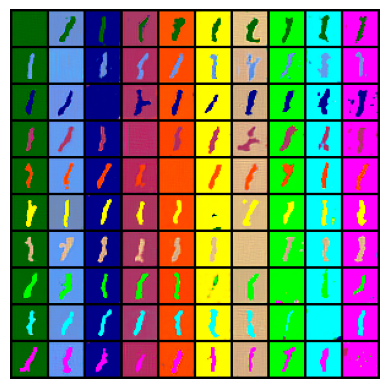

DIGIT: 2


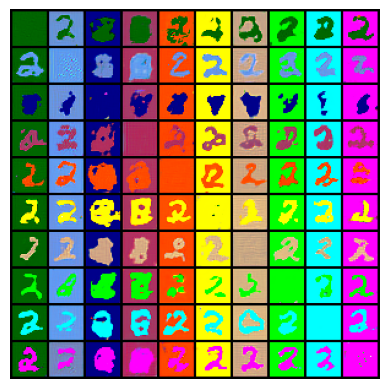

DIGIT: 3


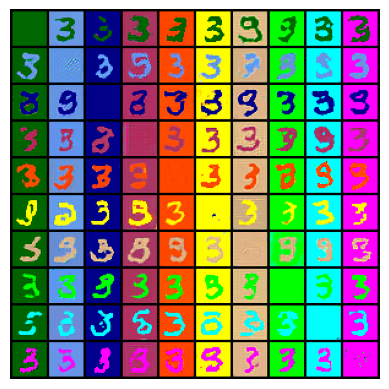

DIGIT: 4


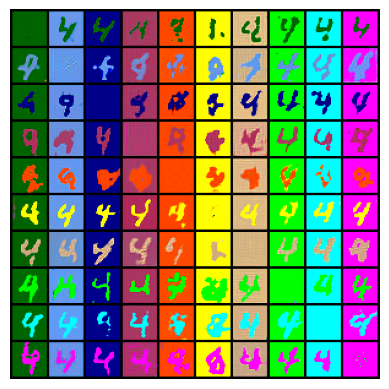

DIGIT: 5


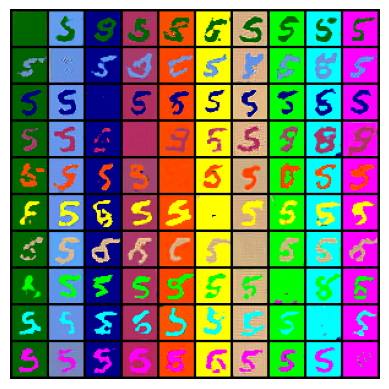

DIGIT: 6


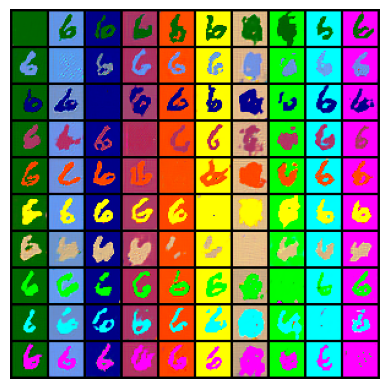

DIGIT: 7


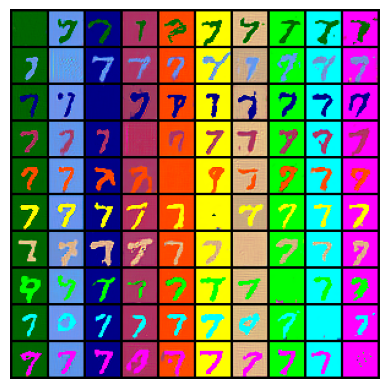

DIGIT: 8


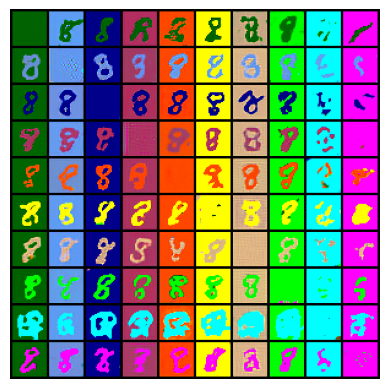

DIGIT: 9


In [ ]:
for digit in range(10):
    print('DIGIT:', digit)
    img_block = []
    for fg_color in range(10):
        img_row = []
        for bg_color in range(10):
            img_row.append(results[str(digit)+str(fg_color)+str(bg_color)])
        img_block.append(torch.concat(img_row, dim=0))
    img_block = torch.stack(img_block, dim=0)
    grid = vutils.make_grid(img_block.flatten(end_dim=1), nrow=10, padding=2)
    plt.imshow(normalize(grid.permute(1,2,0)))
    plt.axis('off')
    plt.show()

In [ ]:
scm_inference = SCM_Inference(vardist_mode, scm_params, vae, BS=1)
test_cvaegan_scm_inference(scm_inference, sigma=sigma.detach().flatten())

  2%|▏         | 3/125 [00:11<07:33,  3.72s/it]


KeyboardInterrupt: 

In [ ]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 4))
# for i in range(3):
#     sns.histplot([winners_train[i], winners_cf[i]], kde=True, stat='probability',
#                  common_norm=False, ax=ax[i])
#     legend = ax[i].get_legend()
#     handles = legend.legend_handles
#     ax[i].legend(handles, ['Train', 'Counterfactual'])
#     ax[i].set_title('Y'+str(i+1))
# plt.tight_layout()

#### 2. With constant sigma


In [ ]:
scm_inference = SCM_Inference(vardist_mode, scm_params, vae, BS=1)
results = defaultdict(list)
for labels in tqdm(label_loader):
    with torch.no_grad():
        zs = []
        for l in labels:
            zs.append(scm_inference.scm_infer(l, torch.ones(10) * sigma.mean()).flatten())
        zs = torch.stack(zs)
        gen_imgs = vae.decoder(zs, labels).detach().cpu()
    for l, gen in zip(labels, gen_imgs):
        results[''.join([str(t) for t in l.tolist()])].append(gen)
for k, img in results.items():
    results[k] = torch.stack(results[k])

100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


DIGIT: 0


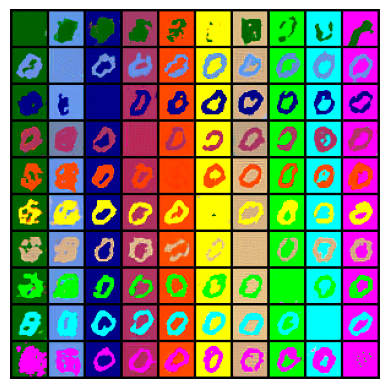

DIGIT: 1


DIGIT: 2


DIGIT: 3


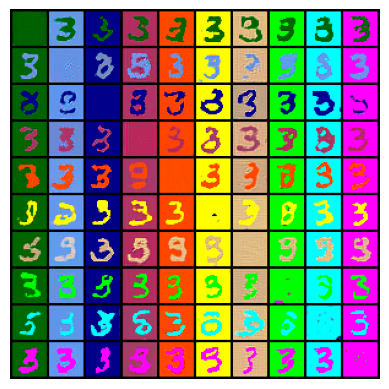

DIGIT: 4


DIGIT: 5


DIGIT: 6


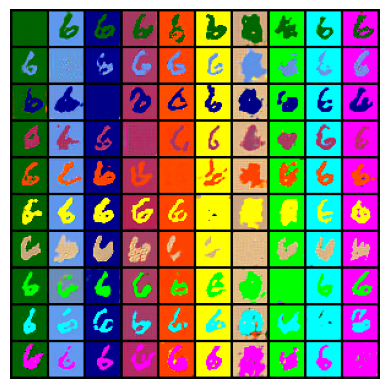

DIGIT: 7


DIGIT: 8


DIGIT: 9


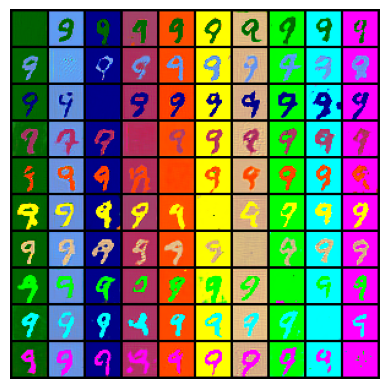

In [ ]:
for digit in range(10):
    print('DIGIT:', digit)
    img_block = []
    for fg_color in range(10):
        img_row = []
        for bg_color in range(10):
            img_row.append(results[str(digit)+str(fg_color)+str(bg_color)])
        img_block.append(torch.concat(img_row, dim=0))
    img_block = torch.stack(img_block, dim=0)
    grid = vutils.make_grid(img_block.flatten(end_dim=1), nrow=10, padding=2)
    plt.imshow(normalize(grid.permute(1,2,0)))
    plt.axis('off')
    plt.show()

In [ ]:
scm_inference = SCM_Inference(vardist_mode, scm_params, vae, BS=1)
test_cvaegan_scm_inference(scm_inference, sigma=torch.ones(10) * sigma.mean())

100%|██████████| 5/5 [00:00<00:00, 15.95it/s]


TRAIN: [0.73058844 0.96243954 0.99102235]
CF:    [0.25418743 0.9959466  0.9990486 ]


#### 2.1. With sigma = 0

In [ ]:
scm_inference = SCM_Inference(vardist_mode, scm_params, vae, BS=1)
results = defaultdict(list)
for labels in tqdm(label_loader):
    with torch.no_grad():
        zs = []
        for l in labels:
            zs.append(scm_inference.scm_infer(l, torch.zeros(10)).flatten())
        zs = torch.stack(zs)
        gen_imgs = vae.decoder(zs, labels).detach().cpu()
    for l, gen in zip(labels, gen_imgs):
        results[''.join([str(t) for t in l.tolist()])].append(gen)
for k, img in results.items():
    results[k] = torch.stack(results[k])

In [ ]:
for digit in range(10):
    print('DIGIT:', digit)
    img_block = []
    for fg_color in range(10):
        img_row = []
        for bg_color in range(10):
            img_row.append(results[str(digit)+str(fg_color)+str(bg_color)])
        img_block.append(torch.concat(img_row, dim=0))
    img_block = torch.stack(img_block, dim=0)
    grid = vutils.make_grid(img_block.flatten(end_dim=1), nrow=10, padding=2)
    plt.imshow(normalize(grid.permute(1,2,0)))
    plt.axis('off')
    plt.show()

In [ ]:
scm_inference = SCM_Inference(vardist_mode, scm_params, vae, BS=1)
test_cvaegan_scm_inference(scm_inference, sigma=torch.zeros(10))

100%|██████████| 5/5 [00:00<00:00, 14.12it/s]



TRAIN: [0.73024225 0.963235   0.9899928 ]
CF:    [0.24993443 0.9947152  0.99830437]


#### 3. Sigma in the top part is smaller than sigma at the bottom


In [ ]:
class SCM_Inference():
    def __init__(self, vardist_mode, scm_params, vae, z_dim=10, num_labels=3,
                 label_sizes=LABEL_SIZES, BS=8, sigma_=0.2):
        self.z_names = ['Z'+str(i) for i in range(z_dim)]
        self.var_names = np.array(['Y'+str(i+1) for i in range(num_labels)] + self.z_names)
        self.feat_dims = {k: ls for k, ls in zip(self.var_names, LABEL_SIZES + list(np.ones(z_dim, dtype=int)))}
        self.name_to_num = {k: i for i, k in enumerate(self.var_names)}
        self.vardist_mode = vardist_mode
        self.scm_params = scm_params
        self.BS = BS
        self.sigma_ = sigma_
        self.vae = vae

    @staticmethod
    def get_onehot_bias(Y_parents, Z_parents):
        if len(Y_parents):
            BS = len(Y_parents[0])
        else:
            BS = len(Z_parents[0])
        onehot_bias = []
        for Y in Y_parents:
            onehot_bias.append(F.one_hot(Y.to(torch.int64), num_classes=10).float())
        for Z in Z_parents:
            onehot_bias.append(Z[:, None])
        onehot_bias.append(torch.ones(BS, 1))
        return torch.cat(onehot_bias, dim=1)

    def get_sample_inf(self, sample_dict, levels_dict, y_dict, var_name):
        '''sample_dict - dict with samples, changing
        y_dict - consts'''

        if var_name in sample_dict:
            return sample_dict, levels_dict
        num = self.name_to_num[var_name]
        parents = self.var_names[self.vardist_mode[:, num].astype(bool)]
        levels_dict[var_name] = 1
        if len(parents) == 0:
            if var_name[0] != 'Y':
                var_mu = self.scm_params['a_'+var_name].repeat(self.BS, 1)
        else:
            Y_parents, Z_parents = [], []
            for parent in parents:
                sample_dict, levels_dict = self.get_sample_inf(sample_dict, levels_dict, y_dict, parent)
                levels_dict[var_name] = max(levels_dict[var_name], levels_dict[parent] + 1)
                if parent[0] == 'Y':
                    Y_parents.append(sample_dict[parent])
                elif parent[0] == 'Z':
                    Z_parents.append(sample_dict[parent])
            var_mu = self.get_onehot_bias(Y_parents, Z_parents) @ self.scm_params['a_'+var_name]
        if var_name[0] == 'Y':
            # no sampling, Ys are given
            sample_dict[var_name] = torch.tensor(y_dict[var_name]).repeat(self.BS)
        else:
            # sampling, Zs are normal
            coef = 1.2 ** levels_dict[var_name]
            sample_dict[var_name] = dist.Normal(var_mu, coef * self.sigma_).sample().flatten()
        return sample_dict, levels_dict

    def scm_infer(self, ys, sigmas):
        # sigmas is not used !
        y_dict = {'Y1': ys[0], 'Y2': ys[1], 'Y3': ys[2]}
        sample_dict = {}
        levels_dict = {}
        for var_name in self.var_names:
            if var_name not in sample_dict:
                sample_dict, levels_dict = self.get_sample_inf(sample_dict, levels_dict, y_dict, var_name)

        z = torch.stack([sample_dict[z] for z in self.z_names]).T
        return z

In [ ]:
scm_inference = SCM_Inference(vardist_mode, scm_params, vae, BS=1)
results = defaultdict(list)
for labels in tqdm(label_loader):
    with torch.no_grad():
        zs = []
        for l in labels:
            zs.append(scm_inference.scm_infer(l).flatten())
        zs = torch.stack(zs)
        gen_imgs = vae.decoder(zs, labels).detach().cpu()
    for l, gen in zip(labels, gen_imgs):
        results[''.join([str(t) for t in l.tolist()])].append(gen)
for k, img in results.items():
    results[k] = torch.stack(results[k])

In [ ]:
for digit in range(10):
    print('DIGIT:', digit)
    img_block = []
    for fg_color in range(10):
        img_row = []
        for bg_color in range(10):
            img_row.append(results[str(digit)+str(fg_color)+str(bg_color)])
        img_block.append(torch.concat(img_row, dim=0))
    img_block = torch.stack(img_block, dim=0)
    grid = vutils.make_grid(img_block.flatten(end_dim=1), nrow=10, padding=2)
    plt.imshow(normalize(grid.permute(1,2,0)))
    plt.axis('off')
    plt.show()

In [ ]:
scm_inference = SCM_Inference(vardist_mode, scm_params, vae, BS=1)
test_cvaegan_scm_inference(scm_inference, sigma=None)

100%|██████████| 5/5 [00:00<00:00,  9.58it/s]



TRAIN: [0.7295874  0.96236664 0.9898792 ]
CF:    [0.24500296 0.9983786  0.98866767]


### 5. Confidence visualization

In [ ]:
winners_train = np.random.rand(3, 100)
winners_cf = np.random.rand(3, 100)

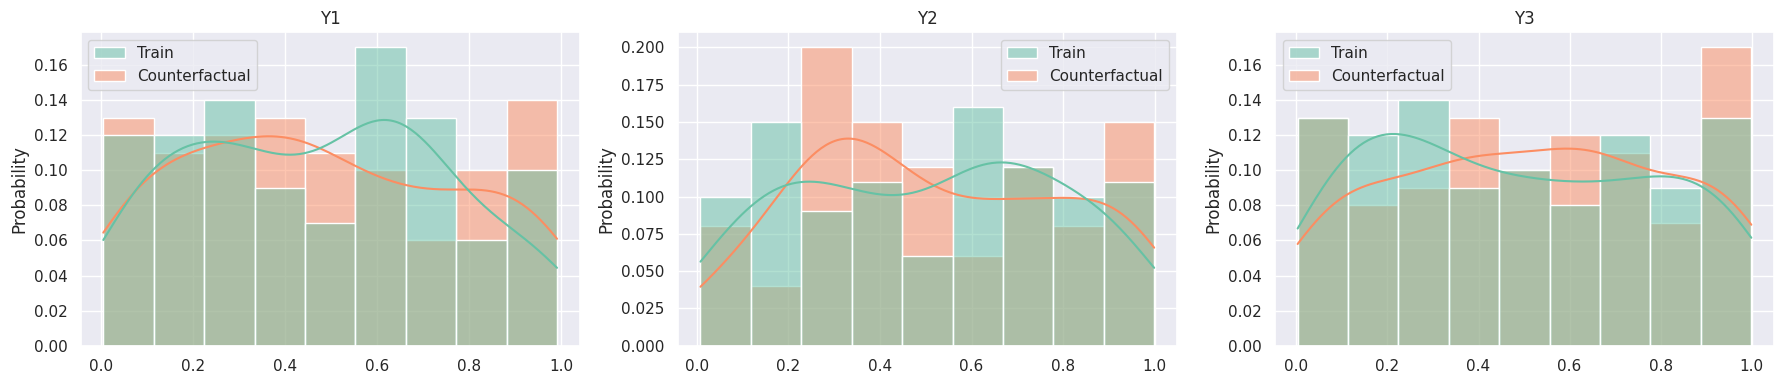

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
for i in range(3):
    sns.histplot([winners_train[i], winners_cf[i]], kde=True, stat='probability',
                 common_norm=False, ax=ax[i])
    legend = ax[i].get_legend()
    handles = legend.legend_handles
    ax[i].legend(handles, ['Train', 'Counterfactual'])
    ax[i].set_title('Y'+str(i+1))
plt.tight_layout()